## Evaluate Llama output

In [276]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from bert_score import plot_example
from bert_score import score
import utils_llama as ulla
from smatch import amr
import pandas as pd
import numpy as np
import sacrebleu
import evaluate
import random
import pickle
import smatch
import nltk
import csv
import re

In [110]:
!pip install smatch

In [280]:
results_llama = 'last_results_llama.pkl'
results = pickle.load(open(results_llama, 'rb'))

In [14]:
with open("../Data/all_merged_data.pkl", "rb") as f:
    all_merged_data = pickle.load(f)

In [199]:
## You can go through the results, e.g. look up specific sentences
for item in results:
    # print(item['scenario'])
    if item['scenario'] == "gesture":
    # print(item['prompt'])
        print(item['llama_1'])
        print(item['sentence'])
        print("----------------------------------------------")

[{"sentence": "Look at the location in front of you.", "speech AMR": "(d/deixis-GA :ARG0 (s/signaler) :ARG1 (f/front) :ARG2 (a/actor))", "explanation": "The gesture labels indicate that the right arm is moving forward, pointing to a location. Then, it moves down and the hand forms a claw shape, before moving up again and pointing forward once more. This sequence of movements suggests that the speaker is directing attention to a specific location in front of them. The gesture AMR confirms this interpretation, with the location being the ARG1."}]
so put put a block on the back block good
----------------------------------------------
[{"sentence": "Put the block in the location, then put another block there.", "speech AMR": "(s/put-01 :ARG0 (b/block) :location (l/location)) (a/and :op1 (s/put-02 :ARG0 (b2/block) :location (l2/location)))", "explanation": "The gesture label indicates that the arms move down into a gap on the left, and the hands are in a claw position. This suggests two se

## BLEU

In [289]:
## Extract all references and generated sentences 

ref_and_transl = []
references = []
candidates = []
for item in results:
    #print(item['sentence'], item['scenario'])
    for key in ["llama_1", "llama_2", "llama_3"]:
        #print(item[key])
        try:
            sentences = re.findall(r'"sentence"\s*:\s*"([^"]+)"', item[key])
            for sent in sentences:
                ref_and_transl.append({
                    "reference": item["sentence"],
                    "scenario": item['scenario'],
                    "llama_run": key,
                    "translation": sent.lower()
                })
                
                # references.append([nltk.word_tokenize(item["sentence"])])
                # candidates.append(nltk.word_tokenize(match.lower()))
                references.append(item['sentence'])
                candidates.append(sent.lower())
                
        except (json.JSONDecodeError, TypeError) as e:
            print(f"Failed to parse {key} {item[key]}\nbecause: {e}.")

# # print(references[0:3])
# # print(candidates[0:3])

for item in ref_and_transl:                       
    if item['reference'] == "just like that but closer together":
        print(item)

{'reference': 'just like that but closer together', 'scenario': 'speech', 'llama_run': 'llama_1', 'translation': 'you should just resemble that, having them close together more.'}
{'reference': 'just like that but closer together', 'scenario': 'speech', 'llama_run': 'llama_2', 'translation': 'you just put that on, though you have to close it together more.'}
{'reference': 'just like that but closer together', 'scenario': 'speech', 'llama_run': 'llama_3', 'translation': "you should just resemble that, but you're having it close together more."}
{'reference': 'just like that but closer together', 'scenario': 'gesture', 'llama_run': 'llama_1', 'translation': 'move back and then move forward into the gap on the left.'}
{'reference': 'just like that but closer together', 'scenario': 'gesture', 'llama_run': 'llama_2', 'translation': 'move back and then point forward.'}
{'reference': 'just like that but closer together', 'scenario': 'gesture', 'llama_run': 'llama_3', 'translation': 'move your

In [291]:
print(len(ref_and_transl))

594


In [1000]:
for item in results:
    print(item['scenario'])
    print(item['prompt'])
    print(item['llama_1'])
    print(item['sentence'])
    print("----------------------------------------------")

speech
Given the following speech Abstract Meaning Representation (AMR), generate a corresponding sentence in natural spoken English. Provide a short explanation. First, read the examples to understand the Abstract Meaning Representation format:

Example 1:
Sentence: okay
Speech AMR:
 (o/okay-04)

Example 2:
Sentence: space two out a little less than a block length
Speech AMR:
 (s/space-01
	:mode imperative
	:ARG0 (y/you)
	:ARG1 (i/implicit-role
		:quant 2)
	:ARG2 (q/distance-quantity
		:unit (b/block)
		:ARG1-of (h/have-quant-91
			:ARG2 1
			:ARG3 (l/less
				:mod (l2/little)))))

Now, generate a sentence from the following speech AMR and explain your reasoning. Please provide the output only in json format:
[{"sentence": "Your generated sentence here.", "explanation": "Your explanation here."}]
Speech AMR:
 (p/put-01
	:mode imperative
	:ARG0 (y/you)
	:ARG1 (b/block
		:quant 1)
	:ARG2 (b2/block
		:mod (b3/back)))

[{"sentence": "Put the back block.", "explanation": "The speech AMR in

In [300]:
## Corpus BLEU score
bleu = sacrebleu.corpus_bleu(candidates, [references])
print(bleu.score)

## Calculate sentence_bleu to see score for individual sentences
for item in ref_and_transl:
    candidate = item['translation']
    reference = item['reference']

    print(f"reference: {reference}\nscenario: {item['scenario']}\ncandidate: {candidate}")
    score = sacrebleu.sentence_bleu(candidate, [reference])
    print(f"{score.score/100:.3f}")
    print(40*"-")

10.958518646956533
0.157
----------------------------------------
0.157
----------------------------------------
0.157
----------------------------------------
0.043
----------------------------------------
0.043
----------------------------------------
0.000
----------------------------------------
0.057
----------------------------------------
0.057
----------------------------------------
0.057
----------------------------------------
0.595
----------------------------------------
0.595
----------------------------------------
0.595
----------------------------------------
0.031
----------------------------------------
0.066
----------------------------------------
0.066
----------------------------------------
0.180
----------------------------------------
0.180
----------------------------------------
0.244
----------------------------------------
1.000
----------------------------------------
1.000
----------------------------------------
1.000
-----------------------------------

In [302]:
## All candidates of speech scenario
speech_references = []
speech_candidates = []
for item in ref_and_transl:
    if item['scenario'] == "speech":
        speech_references.append(item["reference"])
        speech_candidates.append(item['translation'])

speech_score = sacrebleu.corpus_bleu(speech_candidates, [speech_references])
print(speech_score.score)
print(len(speech_candidates))

19.177350373615706
198


In [295]:
## All candidates of gesture scenario
gesture_references = []
gesture_candidates = []
for item in ref_and_transl:
    if item['scenario'] == "gesture":
        gesture_references.append(item["reference"])
        gesture_candidates.append(item['translation'])

gesture_score = sacrebleu.corpus_bleu(gesture_candidates, [gesture_references])
print(gesture_score.score)
print(len(gesture_candidates))

0.6974058412888725
198


In [297]:
## All candidates of gesture+speech scenario
speech_gesture_references = []
speech_gesture_candidates = []
for item in ref_and_transl:
    if item['scenario'] == "speech_gesture":
        speech_gesture_references.append(item["reference"])
        speech_gesture_candidates.append(item['translation'])

speech_gesture_score = sacrebleu.corpus_bleu(speech_gesture_candidates, [speech_gesture_references])
print(speech_gesture_score.score)
print(len(speech_gesture_candidates))

11.168389033086035
198


### Paired Bootstrap Resampling 
check whether the scores are significant

In [308]:
def bootstrap_test_corpus_bleu(refs, sys1, sys2, num_samples=1000, seed=42):
    """
    It tests how much better one system is than another (on average) and whether
    that difference is significant
    Args:
        refs: list of references that you're checking against
        sys1: list of tokenized candidates from first output
        sys2: list of tokenized candidates from second output
        num_samples: number of bootstrap resamples
        seed: seed
    Returns:
        np.mean(diffs): average difference between system 1 and system 2 across all bootstrap samples
        p_value: calculated p_value
    """
    random.seed(seed)
    diffs = []
    refs = [[word_tokenize(r)] for r in refs]  
    sys1 = [word_tokenize(s) for s in sys1]   
    sys2 = [word_tokenize(s) for s in sys2]

    n = len(sys1)
    for _ in range(num_samples):
        indices = [random.randint(0, n - 1) for _ in range(n)]  ## Generate n random indices 1000 times, with replacement
        sample_refs = [refs[i] for i in indices]
        sample_sys1 = [sys1[i] for i in indices]
        sample_sys2 = [sys2[i] for i in indices]

        bleu1 = corpus_bleu(sample_refs, sample_sys1)
        bleu2 = corpus_bleu(sample_refs, sample_sys2)
        diffs.append(bleu1 - bleu2)

    diffs = np.array(diffs)                     ## If diff>0 sys1 performed better, if diff<0 sys2 performed better
    p_value = np.mean(diffs <= 0)               ## Calculate the proportion of bootstrap samples where sys1 was not better than sys2
    return np.mean(diffs), p_value              ## Average observed BLEU difference between the systems, estimated significance

Check whether the BLEU scores for speech and gesture are statistically significant.

In [310]:
## Speech compared to gesture
speech_gesture_mean, speech_gesture_p = bootstrap_test_corpus_bleu(speech_references, speech_candidates, gesture_candidates)
print(f"Speech vs Gesture: ΔBLEU = {speech_gesture_mean:.4f}, p = {speech_gesture_p:.4f}")

C:\Users\Sanne\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Sanne\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Speech vs Gesture: ΔBLEU = 0.1856, p = 0.0000


ΔBLEU = 0.1856:
The speech system's corpus BLEU score is on average 18.56% higher than the gesture system's across the sampled bootstrap runs

p = 0.000 (i.e., p < 0.001):
The probability that gesture otperforms or equals speech just by chance is essentially zero. This means the difference is statistically significant. You can confidently conclude: 
speech-based outputs are significantly better than gesture-based ones under BLEU evaluatio

In [311]:
## Speech compared to speech+gesture
s_sg_mean, s_sg_p = bootstrap_test_corpus_bleu(speech_references, speech_candidates, speech_gesture_candidates)
print(f"Speech vs Speech+Gesture: ΔBLEU = {s_sg_mean:.4f}, p = {s_sg_p:.4f}")

# ΔBLEU = 0.0765:
# The speech system’s corpus BLEU score is on average 7.65 percentage points higher than the 
# speech+gesture system’s across the sampled bootstrap runs. This is a substantial performance gap.

Speech vs Speech+Gesture: ΔBLEU = 0.0765, p = 0.0000


ΔBLEU = 0.0765:
The speech system's corpus BLEU score is on average 7.65& higher than the speech+gesture system's across the samples bootstrap runs

In [312]:
## Gesture compared to speech+gesture
g_sg_mean, g_sg_p = bootstrap_test_corpus_bleu(gesture_references, gesture_candidates, speech_gesture_candidates)
print(f"Gesture vs Speech+Gesture: ΔBLEU = {g_sg_mean:.4f}, p = {g_sg_p:.4f}")

C:\Users\Sanne\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Sanne\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Gesture vs Speech+Gesture: ΔBLEU = -0.1091, p = 1.0000


ΔBLEU = -0.1091:
The BLEU score for gesture-only output is 0.1091 lower on average than for speech+gesture output. 
p = 1.0000 means that in all bootstrap samples, gesture performed worse than (or equal to) speech+gesture, never better. Therefore the BLEU difference is highly statistically significant, and gesture-only underperforms compared to speech+gesture

## METEOR

In [404]:
## Calculate METEOR score for all sentences
sent_count = 0
total_score = 0
for item in ref_and_transl:
    candidate = (item['translation']).strip()
    reference = (item['reference']).strip()
    print(f"reference: {reference}\nscenario: {item['scenario']}\ncandidate: {candidate}")

    score = meteor_score([word_tokenize(reference)], word_tokenize(candidate))
    print(f"{score:.3f}")
    sent_count+=1
    total_score+=score
    print(40*"-")
print(f"Average METEOR score: {(total_score/sent_count):.4f}")  

reference: so put put a block on the back block good
scenario: speech
candidate: put the back block.
0.395
----------------------------------------
reference: so put put a block on the back block good
scenario: speech
candidate: put the back block.
0.395
----------------------------------------
reference: so put put a block on the back block good
scenario: speech
candidate: put the back block.
0.395
----------------------------------------
reference: so put put a block on the back block good
scenario: gesture
candidate: look at the location in front of you.
0.051
----------------------------------------
reference: so put put a block on the back block good
scenario: gesture
candidate: look at the location in front of you.
0.051
----------------------------------------
reference: so put put a block on the back block good
scenario: gesture
candidate: look over there.
0.000
----------------------------------------
reference: so put put a block on the back block good
scenario: speech_gestur

In [722]:
## Calculate METEOR score for all speech condition sentences
speech_sent_count = 0
speech_total_score = 0

sp_meteor_ref, sp_meteor_cand = [], []
for item in ref_and_transl:
    if item['scenario'] == "speech":
        candidate = (item['translation']).strip()
        reference = (item['reference']).strip()

        sp_meteor_ref.append(word_tokenize(reference))
        sp_meteor_cand.append(word_tokenize(candidate))

        score = meteor_score([word_tokenize(reference)], word_tokenize(candidate))
        speech_sent_count+=1
        speech_total_score+=score
print(f"Average METEOR score speech scenario: {(speech_total_score/speech_sent_count):.4f}") 

Average METEOR score speech scenario: 0.4671


In [744]:
## Calculate METEOR score for all gesture condition sentences
gesture_sent_count = 0
gesture_total_score = 0

gest_meteor_cand = []
for item in ref_and_transl:
    if item['scenario'] == "gesture":
        candidate = (item['translation']).strip()
        reference = (item['reference']).strip()

        gest_meteor_cand.append(word_tokenize(candidate))

        score = meteor_score([word_tokenize(reference)], word_tokenize(candidate))
        gesture_sent_count+=1
        gesture_total_score+=score
print(f"Average METEOR score gesture scenario: {(gesture_total_score/gesture_sent_count):.4f}") 

Average METEOR score gesture scenario: 0.0715


In [742]:
## Calculate METEOR score for all speech+gesture condition sentences
speech_gesture_sent_count = 0
speech_gesture_total_score = 0

sp_gest_meteor_cand = []
for item in ref_and_transl:
    if item['scenario'] == "speech_gesture":
        candidate = (item['translation']).strip()
        reference = (item['reference']).strip()

        sp_gest_meteor_cand.append(word_tokenize(candidate))

        score = meteor_score([word_tokenize(reference)], word_tokenize(candidate))
        speech_gesture_sent_count+=1
        speech_gesture_total_score+=score
print(f"Average METEOR score speech+gesture scenario: {(speech_gesture_total_score/speech_gesture_sent_count):.4f}") 

Average METEOR score speech+gesture scenario: 0.3180


## Paired Bootstrap Resampling

In [728]:
def bootstrap_test_meteor(refs, sys1, sys2, num_samples=1000, seed=42):
    """
    It tests how much better one system is than another (on average) and whether
    that difference is significant
    Args:
        refs: list of references that you're checking against
        sys1: list of tokenized candidates from first output
        sys2: list of tokenized candidates from second output
        num_samples: number of bootstrap resamples
        seed: seed
    Returns:
        np.mean(diffs): average difference between system 1 and system 2 across all bootstrap samples
        p_value: calculated p_value
    """
    random.seed(seed)
    diffs = []

    n = len(sys1)
    for _ in range(num_samples):
        indices = [random.randint(0, n - 1) for _ in range(n)]  ## Generate n random indices 1000 times, with replacement
        sample_refs = [refs[i] for i in indices]
        sample_sys1 = [sys1[i] for i in indices]
        sample_sys2 = [sys2[i] for i in indices]

        meteor1 = np.mean([
            meteor_score([sample_refs[i]], sample_sys1[i])
            for i in range(n)
        ]) 

        meteor2 = np.mean([
            meteor_score([sample_refs[i]], sample_sys2[i])
            for i in range(n)
        ])

        diffs.append(meteor1 - meteor2)

    diffs = np.array(diffs)                     ## If diff>0 sys1 performed better, if diff<0 sys2 performed better
    p_value = np.mean(diffs <= 0)               ## Calculate the proportion of bootstrap samples where sys1 was not better than sys2
    return np.mean(diffs), p_value              ## Average observed BLEU difference between the systems, estimated significance

In [734]:
## Speech compared to gesture
sg_mean_meteor, sg_p_meteor = bootstrap_test_meteor(sp_meteor_ref, sp_meteor_cand, gest_meteor_cand)
print(f"Speech vs Gesture: ΔMETEOR = {sg_mean_meteor:.4f}, p = {sg_p_meteor:.4f}")

Speech vs Gesture: ΔMETEOR = 0.3954, p = 0.0000


In [748]:
## Speech compared to speech+gesture
ssg_mean_meteor, ssg_p_meteor = bootstrap_test_meteor(sp_meteor_ref, sp_meteor_cand, sp_gest_meteor_cand)
print(f"Speech vs Speech+Gesture: ΔMETEOR = {ssg_mean_meteor:.4f}, p = {ssg_p_meteor:.4f}")

Speech vs Speech+Gesture: ΔMETEOR = 0.1492, p = 0.0000


In [749]:
## Gesture compared to speech+gesture
## All references are the same so I reuse sp_meteor_ref
gsg_mean_meteor, gsg_p_meteor = bootstrap_test_meteor(sp_meteor_ref, gest_meteor_cand, sp_gest_meteor_cand)
print(f"Gesture vs Speech+Gesture: ΔMETEOR = {gsg_mean_meteor:.4f}, p = {gsg_p_meteor:.4f}")

Gesture vs Speech+Gesture: ΔMETEOR = -0.2461, p = 1.0000


## BERTScore

In [860]:
## All sentences
ref_and_transl_bert = []
references = []
candidates = []
for item in results:
    #print(item['sentence'], item['scenario'])
    for key in ["llama_1", "llama_2", "llama_3"]:
        #print(item[key])
        try:
            matches = re.findall(r'"sentence"\s*:\s*"([^"]+)"', item[key])
            for match in matches:
                #print(match)
                ref_and_transl_bert.append({
                    "reference": item["sentence"],
                    "scenario": item['scenario'],
                    "translation": match.lower()
                })
                references.append(item["sentence"])
                candidates.append(match.lower())
                
        except (json.JSONDecodeError, TypeError) as e:
            print(f"Failed to parse {key} {item[key]}\nbecause: {e}.")

print(references[0:50])
print("----------------------------")
print(candidates[0:50])

['so put put a block on the back block good', 'so put put a block on the back block good', 'so put put a block on the back block good', 'so put put a block on the back block good', 'so put put a block on the back block good', 'so put put a block on the back block good', 'so put put a block on the back block good', 'so put put a block on the back block good', 'so put put a block on the back block good', 'put two blocks', 'put two blocks', 'put two blocks', 'put two blocks', 'put two blocks', 'put two blocks', 'put two blocks', 'put two blocks', 'put two blocks', 'um', 'um', 'um', 'um', 'um', 'um', 'um', 'um', 'um', 'and then put one on the top', 'and then put one on the top', 'and then put one on the top', 'and then put one on the top', 'and then put one on the top', 'and then put one on the top', 'and then put one on the top', 'and then put one on the top', 'and then put one on the top', "no that doesn't look like it’s going to work", "no that doesn't look like it’s going to work", "no

In [867]:
precision, recall, f1 = score(candidates, references, lang="en", model_type="bert-base-uncased") 

C:\Users\Sanne\anaconda3\Lib\site-packages\bert_score\score.py:316: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


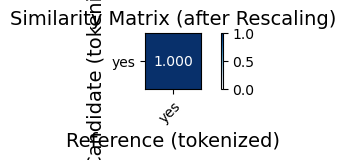

In [907]:
plot_example(candidates[45], references[45], lang="en", model_type="bert-base-uncased", rescale_with_baseline=True)

In [523]:
print(f"Average F1 score: {f1.mean():.4f}")
print(f"Average precision: {precision.mean():.4f}")
print(f"Average recall: {recall.mean():.4f}")

Average F1 score: 0.5382
Average precision: 0.5371
Average recall: 0.5455


In [844]:
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Example {i+1}")
    print(f"Reference : {references[i]}")
    print(f"Prediction: {candidates[i]}")
    print(f"BERTScore F1: {f.item():.4f}")
    print(f"BERTScore precision: {p.item():.4f}")
    print(f"BERTScore recall: {r.item():.4f}")
    # if p < 0.30:
    #     print(f"Reference : {references[i]}")
    #     print(f"Prediction: {candidates[i]}")
    #     print(f"BERTScore precision: {p.item():.4f}")

Example 1
Reference : so put put a block on the back block good
Prediction: put the back block.
BERTScore F1: 0.7119
BERTScore precision: 0.7418
BERTScore recall: 0.6844
Example 2
Reference : so put put a block on the back block good
Prediction: put the back block.
BERTScore F1: 0.7119
BERTScore precision: 0.7418
BERTScore recall: 0.6844
Example 3
Reference : so put put a block on the back block good
Prediction: put the back block.
BERTScore F1: 0.7119
BERTScore precision: 0.7418
BERTScore recall: 0.6844
Example 4
Reference : so put put a block on the back block good
Prediction: look at the location in front of you.
BERTScore F1: 0.4456
BERTScore precision: 0.4315
BERTScore recall: 0.4607
Example 5
Reference : so put put a block on the back block good
Prediction: look at the location in front of you.
BERTScore F1: 0.4456
BERTScore precision: 0.4315
BERTScore recall: 0.4607
Example 6
Reference : so put put a block on the back block good
Prediction: look over there.
BERTScore F1: 0.4180


In [528]:
## All candidates of speech scenario
speech_references = []
speech_candidates = []
for item in ref_and_transl_bert:
    # print(item)
    if item['scenario'] == "speech":
        speech_references.append(item['reference'])
        speech_candidates.append(item['translation'])

speech_precision, speech_recall, speech_f1 = score(speech_candidates, speech_references, lang="en", model_type="bert-base-uncased")
print(f"Average F1 score speech: {speech_f1.mean():.4f}")
print(f"Average precision speech: {speech_precision.mean():.4f}")
print(f"Average recall speech: {speech_recall.mean():.4f}")

Average F1 score speech: 0.6604
Average precision speech: 0.6609
Average recall speech: 0.6653


In [530]:
## All candidates of gesture scenario
gesture_references = []
gesture_candidates = []
for item in ref_and_transl_bert:
    #print(item)
    if item['scenario'] == "gesture":
        gesture_references.append(item['reference'])
        gesture_candidates.append(item['translation'])

gesture_precision, gesture_recall, gesture_f1 = score(gesture_candidates, gesture_references, lang="en", model_type="bert-base-uncased")
print(f"Average F1 score gesture: {gesture_f1.mean():.4f}")
print(f"Average precision gesture: {gesture_precision.mean():.4f}")
print(f"Average recall gesture: {gesture_recall.mean():.4f}")

Average F1 score gesture: 0.4053
Average precision gesture: 0.4035
Average recall gesture: 0.4134


In [532]:
## All candidates of speech+gesture scenario
sp_gest_references = []
sp_gest_candidates = []
for item in ref_and_transl_bert:
    #print(item)
    if item['scenario'] == "speech_gesture":
        sp_gest_references.append(item['reference'])
        sp_gest_candidates.append(item['translation'])

sp_gest_precision, sp_gest_recall, sp_gest_f1 = score(sp_gest_candidates, sp_gest_references, lang="en", model_type="bert-base-uncased")
print(f"Average F1 score gesture: {sp_gest_f1.mean():.4f}")
print(f"Average precision gesture: {sp_gest_precision.mean():.4f}")
print(f"Average recall gesture: {sp_gest_recall.mean():.4f}")

Average F1 score gesture: 0.5488
Average precision gesture: 0.5469
Average recall gesture: 0.5578


## Paired Bootstrap Resampling

In [776]:
def bootstrap_test_bertscore(sys1_scores, sys2_scores, num_samples=1000, seed=42):
    """
    It tests how much better one system is than another (on average) and whether
    that difference is significant
    Args:
        refs: list of references that you're checking against
        sys1: list of tokenized candidates from first output
        sys2: list of tokenized candidates from second output
        num_samples: number of bootstrap resamples
        seed: seed
    Returns:
        np.mean(diffs): average difference between system 1 and system 2 across all bootstrap samples
        p_value: calculated p_value
    """
    random.seed(seed)
    diffs = []

    sys1_scores = np.array(sys1_scores)
    sys2_scores = np.array(sys2_scores)

    n = len(sys1_scores)
    for _ in range(num_samples):
        indices = [random.randint(0, n - 1) for _ in range(n)]  ## Generate n random indices 1000 times, with replacement
        sample_sys1 = [sys1_scores[i] for i in indices]
        sample_sys2 = [sys2_scores[i] for i in indices]

        mean1 = np.mean(sample_sys1)
        mean2 = np.mean(sample_sys2)

        diffs.append(mean1 - mean2)

    diffs = np.array(diffs)                     ## If diff>0 sys1 performed better, if diff<0 sys2 performed better
    p_value = np.mean(diffs <= 0)               ## Calculate the proportion of bootstrap samples where sys1 was not better than sys2
    return np.mean(diffs), p_value              ## Average observed BLEU difference between the systems, estimated significance

In [778]:
## Speech compared to gesture
delta_precision, p_precision = bootstrap_test_bertscore(speech_precision, gesture_precision)
delta_recall, p_recall = bootstrap_test_bertscore(speech_recall, gesture_recall)
delta_f1, p_f1 = bootstrap_test_bertscore(speech_f1, gesture_f1)

print(f"Speech vs Gesture BERTScore Δprecision = {delta_precision:.4f}, p = {p_precision:.4f}")
print(f"Speech vs Gesture BERTScore Δrecall = {delta_recall:.4f}, p = {p_recall:.4f}")
print(f"Speech vs Gesture BERTScore f1 = {delta_f1:.4f}, p = {p_f1:.4f}")

Speech vs Gesture BERTScore Δprecision = 0.2573, p = 0.0000
Speech vs Gesture BERTScore Δrecall = 0.2517, p = 0.0000
Speech vs Gesture BERTScore f1 = 0.2549, p = 0.0000


In [780]:
## Speech compared to speech+gesture
delta_precision, p_precision = bootstrap_test_bertscore(speech_precision, sp_gest_precision)
delta_recall, p_recall = bootstrap_test_bertscore(speech_recall, sp_gest_recall)
delta_f1, p_f1 = bootstrap_test_bertscore(speech_f1, sp_gest_f1)

print(f"Speech vs Speech+Gesture BERTScore Δprecision = {delta_precision:.4f}, p = {p_precision:.4f}")
print(f"Speech vs Speech+Gesture BERTScore Δrecall = {delta_recall:.4f}, p = {p_recall:.4f}")
print(f"Speech vs Speech+Gesture BERTScore f1 = {delta_f1:.4f}, p = {p_f1:.4f}")

Speech vs Speech+Gesture BERTScore Δprecision = 0.1142, p = 0.0000
Speech vs Speech+Gesture BERTScore Δrecall = 0.1076, p = 0.0000
Speech vs Speech+Gesture BERTScore f1 = 0.1117, p = 0.0000


In [781]:
## Gesture compared to speech+gesture
delta_precision, p_precision = bootstrap_test_bertscore(gesture_precision, sp_gest_precision)
delta_recall, p_recall = bootstrap_test_bertscore(gesture_recall, sp_gest_recall)
delta_f1, p_f1 = bootstrap_test_bertscore(gesture_f1, sp_gest_f1)

print(f"Gesture vs Speech+Gesture BERTScore Δprecision = {delta_precision:.4f}, p = {p_precision:.4f}")
print(f"Gesture vs Speech+Gesture BERTScore Δrecall = {delta_recall:.4f}, p = {p_recall:.4f}")
print(f"Gesture vs Speech+Gesture BERTScore f1 = {delta_f1:.4f}, p = {p_f1:.4f}")

Gesture vs Speech+Gesture BERTScore Δprecision = -0.1431, p = 1.0000
Gesture vs Speech+Gesture BERTScore Δrecall = -0.1440, p = 1.0000
Gesture vs Speech+Gesture BERTScore f1 = -0.1433, p = 1.0000


## AMR evaluation using Smatch

In [42]:
test_dataframe = "test_df.pkl"
example_dataframe = "example_df.pkl"
test_df = pickle.load(open(test_dataframe, 'rb'))
example_df = pickle.load(open(example_dataframe, 'rb'))

In [116]:
## Extract all gold speech AMRs
gold_speech_df = test_df[test_df['prompt_type'] == 'speech']

## There are 3 runs for 1 sentence, so each entry needs to be included three times
repeat_gold_speech_df = gold_speech_df.loc[gold_speech_df.index.repeat(3)].reset_index(drop=True)

gold_speech_amrs = repeat_gold_speech_df['speech_amr'].tolist()
for item in gold_speech_amrs:
    print(item)

(p / put-01  :mode imperative  :ARG0 (y / you)  :ARG1 (b / block   :quant 1)  :ARG2 (b2 / block    :mod (b3 / back)))
(p / put-01  :mode imperative  :ARG0 (y / you)  :ARG1 (b / block   :quant 1)  :ARG2 (b2 / block    :mod (b3 / back)))
(p / put-01  :mode imperative  :ARG0 (y / you)  :ARG1 (b / block   :quant 1)  :ARG2 (b2 / block    :mod (b3 / back)))
(p / put-01  :mode imperative  :ARG0 (y / you)  :ARG1 (b / block   :quant 2))
(p / put-01  :mode imperative  :ARG0 (y / you)  :ARG1 (b / block   :quant 2))
(p / put-01  :mode imperative  :ARG0 (y / you)  :ARG1 (b / block   :quant 2))
(u / um  :mode expressive)
(u / um  :mode expressive)
(u / um  :mode expressive)
(a / and  :op2 (p / put-01   :mode imperative   :time (t / then)   :ARG0 (y / you)   :ARG1 (o / one)   :ARG2 (o2 / on    :op1 (t2 / top))))
(a / and  :op2 (p / put-01   :mode imperative   :time (t / then)   :ARG0 (y / you)   :ARG1 (o / one)   :ARG2 (o2 / on    :op1 (t2 / top))))
(a / and  :op2 (p / put-01   :mode imperative   :ti

In [182]:
## Extract the AMRs generated by Llama for the gesture condition
sent_and_amr = []
for item in results:   
    if item["scenario"] == "gesture":
        for key in ["llama_1", "llama_2", "llama_3"]:
            try:
                amr_matches = re.findall(r'"speech AMR"\s*:\s*"([^"]+)"', item[key])
                sent_matches = re.findall(r'"sentence"\s*:\s*"([^"]+)"', item[key])
                for amr_match, sent_match in zip(amr_matches, sent_matches):
                    sent_and_amr.append({
                        "reference": item["sentence"],
                        "speech AMR": amr_match,
                        "llama_run": key,
                        "translation": sent_match.lower()
                    })
            except (json.JSONDecodeError, TypeError) as e:
                print(f"Failed to parse {key} {item[key]}\nbecause: {e}.")

llama_amr = []
for item in sent_and_amr:
    llama_amr.append(item["speech AMR"])

for item in llama_amr:
    print(item)

(d/deixis-GA :ARG0 (s/signaler) :ARG1 (f/front) :ARG2 (a/actor))
(d/deixis-GA :ARG0 (s/signaler) :ARG1 (f/front) :ARG2 (a/actor))
(d/deixis-GA :ARG0 (s/signaler) :ARG1 (l/location) :ARG2 (a/actor))
(s/put-01 :ARG0 (b/block) :location (l/location)) (a/and :op1 (s/put-02 :ARG0 (b2/block) :location (l2/location)))
(s/put-01 :ARG0 (i/it) :ARG1 (b/block) :location (l/location))
(s/put-01 :ARG0 (i/it) :ARG1 (b/block) :location (d/deixis-GA :ARG0 s :ARG1 (l/location) :ARG2 a2))
(m/move-01 :mode imperative :ARG0 (y/you) :ARG1 (b/block :mod (d/down)) :ARG2 (a/actor))
(m/move-01 :mode imperative :ARG0 (y/you) :ARG1 (b/block :mod (d/down))
(p/put-01 :mode imperative :ARG0 (y/you) :ARG1 (b/block :mod (d/down)) :ARG2 (a/actor))
(d/deixis-01 :mode declarative :ARG0 (y/you) :ARG1 (l/location))
(d/deixis-01 :mode declarative :ARG0 (y/you) :ARG1 (l/location))
(i/icon-GA :ARG0 (s/signaler) :ARG1 (t/that) :ARG2 (a/actor))
(i/icon-GA :ARG0 (s/signaler) :ARG1 (g/grab-01 :ARG1 (b/block :quant 2)) :ARG2 (a/a

In [178]:
## Check gold and predictions are the same length
print(len(llama_amr))
print(len(gold_speech_amrs))

total_matched = 0
total_gold = 0
total_pred = 0

for gold, pred in zip(gold_speech_amrs, llama_amr):
    try:
        amr_gold = amr.AMR.parse_AMR_line(gold)
        amr_pred = amr.AMR.parse_AMR_line(pred)
        if amr_gold is None or amr_pred is None:                   ## Many AMRs generated by Llama are invalid, these are skipped
            print("Invalid AMR detected. Skipping...")
            continue
        matched, gold_score, pred_score = smatch.get_amr_match(gold, pred)
        
        total_matched += matched
        total_gold += gold_score
        total_pred += pred_score
    except Exception as e:                 
        print(f"Error parsing AMR: {e}")

precision = total_matched / total_pred if total_pred > 0 else 0
recall = total_matched / total_gold if total_gold > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print(f"Average precision: {precision:.3f}")
print(f"Average recall: {recall:.3f}")
print(f"Average f1: {f1:.3f}")

Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Error parsing AMR: list index out of range
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Invalid AMR detected. Skipping...
Inval

Duplicate node name  s  in parsing AMR
Duplicate node name  i  in parsing AMR
Error in parsing AMR (c/count-01 :mode imperative :ARG0 (s/signaler) :ARG1 (a/actor)) (d/deixis-GA :ARG0 s :ARG1 b/
Duplicate node name  a  in parsing AMR
Unmatched parenthesis at position 188 in processing (b / block   :quant 1   :location (o / on-top-of               :op1 (b2 / block                      :mod (t / that)                      :quant (e / each)                      :quant 2))))
Unmatched parenthesis at position 188 in processing (b / block   :quant 1   :location (o / on-top-of               :op1 (b2 / block                      :mod (t / that)                      :quant (e / each)                      :quant 2))))
Unmatched parenthesis at position 188 in processing (b / block   :quant 1   :location (o / on-top-of               :op1 (b2 / block                      :mod (t / that)                      :quant (e / each)                      :quant 2))))
Error processing (o/ok :op1) op1
Duplicat